# Linguistic Data Final Project

* Members:
  * 🇰🇷 `Taekwan Yang`
    * Found the dataset
    * Setup libraries, load the data, and first part of EDA
    * Refactored and organized the majority of code
    * Tokenizer functions using NLP library
    * Drawing regression line and conducting statistical tests
    * KDE plot and word cloud visualization
    * Conclusion of the first hypothesis
  * 🇰🇷 `Ji Hoo Kang`
    * Preparing data
    * Scatter plot visualization
    * First hypothesis
    * Second hypothesis
    * Conclusion of second hypothesis

#### Mounting google drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Setup libraries

In [ ]:
import gc
import numpy as np
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from datascience import *
from scipy.stats import pearsonr, spearmanr
from wordcloud import WordCloud
%matplotlib inline

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# 2. Load the data

In [ ]:
dpath = 'drive/Shareddrives/2022 Linguistic Data/nytimes_lead_paragraphs_Sep-1851-July-2017.csv'
df = pd.read_csv(dpath, sep='\t')

# 3. Exploratory Data Analysis

## How big is the data?

In [ ]:
print('Number of rows:', len(df))
print('Number of columns:', len(df.columns))

Number of rows: 8006768
Number of columns: 2


## How does the data look like?

In [ ]:
df.head()

,DATE,LEAD_PARAGRAPH
0,1851-09-18T00:03:58Z,THE UNITED STATES DISTRICT COURT--Before Judge...
1,1851-09-18T00:03:58Z,"In February, 1849, The Times directed public a..."
2,1851-09-18T00:03:58Z,Our readers have undoubtedly made themselves f...
3,1851-09-18T00:03:58Z,Old sporting-men know very well what snapshoot...
4,1851-09-18T00:03:58Z,The weather was the theme upon which we hinged...


In [ ]:
df.describe()

,DATE,LEAD_PARAGRAPH
count,8006768,8005181
unique,381601,7818434
top,1980-10-12T00:00:00Z,LEAD: To the Editor:
freq,1029,13198


## Preparing the data

In [ ]:
def stod(s):
  return date(int(s[:4]), int(s[5:7]), int(s[8:10]))

df2 = df.iloc[::1000,:].reset_index()
df2['INT_DATE'] = [0] * len(df2['DATE'])
begin_date = stod(df2['DATE'][0])

for i in range(len(df2)):
  date2 = stod(df2['DATE'][i])
  df2['INT_DATE'][i] = (date2 - begin_date).days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
def tokenizer(x):
  return [e.lower() for e in word_tokenize(x) if not re.match(r'^[_\W]+$', e)]

def get_tokens_lengths(tokens):
  return list(map(len, tokens))

def avg_word_len(len_tokens):
  if len(len_tokens) == 0:
    return 0
  return sum(len_tokens)/len(len_tokens)
  
def get_num_uniq_tokens(tokens):
  return len(set(tokens))

def get_sents(x):
  sents = sent_tokenize(x)
  for i in range(len(sents)):
    sents[i] = [e.lower() for e in word_tokenize(sents[i]) if not re.match(r'^[_\W]+$', e)]
  return sents

def minn(tokens):
  if len(tokens) == 0:
    return 0
  return min(tokens)

def maxx(tokens):
  if len(tokens) == 0:
    return 0
  return max(tokens)

In [ ]:
t = Table().from_df(df2)
t = t.with_columns('TOKENS', t.apply(tokenizer, 'LEAD_PARAGRAPH'))
t.show(5)

/usr/local/lib/python3.7/dist-packages/datascience/tables.py:558: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([fn(*row) for row in rows])


index,DATE,LEAD_PARAGRAPH,INT_DATE,TOKENS
0,1851-09-18T00:03:58Z,THE UNITED STATES DISTRICT COURT--Before Judge BETTS.--T ...,0,"['the', 'united', 'states', 'district', 'court', 'before ..."
1000,1851-10-25T00:03:58Z,"In Steamer Atlantic for Liverpool.--Nelson Smith, of New ...",37,"['in', 'steamer', 'atlantic', 'for', 'liverpool.', 'nels ..."
2000,1851-12-13T00:03:58Z,The Courier and Enquirer dwells upon the power of Russia ...,86,"['the', 'courier', 'and', 'enquirer', 'dwells', 'upon', ..."
3000,1852-02-09T00:03:58Z,"KOSSUTH was presented to the Legislature of Ohio to-day, ...",144,"['kossuth', 'was', 'presented', 'to', 'the', 'legislatur ..."
4000,1852-04-02T00:03:58Z,Foreign Exchanges are more in favor of England. Amsterda ...,197,"['foreign', 'exchanges', 'are', 'more', 'in', 'favor', ' ..."


In [ ]:
t = t.with_columns('LEN_TOKENS', t.apply(get_tokens_lengths, 'TOKENS')).drop('index').drop('DATE')
t.show(5)

/usr/local/lib/python3.7/dist-packages/datascience/tables.py:558: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([fn(*row) for row in rows])


LEAD_PARAGRAPH,INT_DATE,TOKENS,LEN_TOKENS
THE UNITED STATES DISTRICT COURT--Before Judge BETTS.--T ...,0,"['the', 'united', 'states', 'district', 'court', 'before ...","[3, 6, 6, 8, 5, 6, 5, 6, 3, 5, 4, 4, 4, 5, 4, 4, 5, 2, 3 ..."
"In Steamer Atlantic for Liverpool.--Nelson Smith, of New ...",37,"['in', 'steamer', 'atlantic', 'for', 'liverpool.', 'nels ...","[2, 7, 8, 3, 10, 6, 5, 2, 8, 5, 6, 2, 12, 5, 6, 2, 6, 2, ..."
The Courier and Enquirer dwells upon the power of Russia ...,86,"['the', 'courier', 'and', 'enquirer', 'dwells', 'upon', ...","[3, 7, 3, 8, 6, 4, 3, 5, 2, 6, 2, 10, 2, 4, 3, 6, 2, 3, ..."
"KOSSUTH was presented to the Legislature of Ohio to-day, ...",144,"['kossuth', 'was', 'presented', 'to', 'the', 'legislatur ...","[7, 3, 9, 2, 3, 11, 2, 4, 6, 2, 2, 7, 2, 3, 8, 2, 5, 8, ..."
Foreign Exchanges are more in favor of England. Amsterda ...,197,"['foreign', 'exchanges', 'are', 'more', 'in', 'favor', ' ...","[7, 9, 3, 4, 2, 5, 2, 7, 9, 4, 3, 9, 5, 5, 5, 3, 9, 2, 3 ..."


In [ ]:
t = t.with_columns('NUM_TOKENS', t.apply(len, 'LEN_TOKENS'))
t.show(5)

LEAD_PARAGRAPH,INT_DATE,TOKENS,LEN_TOKENS,NUM_TOKENS
THE UNITED STATES DISTRICT COURT--Before Judge BETTS.--T ...,0,"['the', 'united', 'states', 'district', 'court', 'before ...","[3, 6, 6, 8, 5, 6, 5, 6, 3, 5, 4, 4, 4, 5, 4, 4, 5, 2, 3 ...",48
"In Steamer Atlantic for Liverpool.--Nelson Smith, of New ...",37,"['in', 'steamer', 'atlantic', 'for', 'liverpool.', 'nels ...","[2, 7, 8, 3, 10, 6, 5, 2, 8, 5, 6, 2, 12, 5, 6, 2, 6, 2, ...",68
The Courier and Enquirer dwells upon the power of Russia ...,86,"['the', 'courier', 'and', 'enquirer', 'dwells', 'upon', ...","[3, 7, 3, 8, 6, 4, 3, 5, 2, 6, 2, 10, 2, 4, 3, 6, 2, 3, ...",53
"KOSSUTH was presented to the Legislature of Ohio to-day, ...",144,"['kossuth', 'was', 'presented', 'to', 'the', 'legislatur ...","[7, 3, 9, 2, 3, 11, 2, 4, 6, 2, 2, 7, 2, 3, 8, 2, 5, 8, ...",71
Foreign Exchanges are more in favor of England. Amsterda ...,197,"['foreign', 'exchanges', 'are', 'more', 'in', 'favor', ' ...","[7, 9, 3, 4, 2, 5, 2, 7, 9, 4, 3, 9, 5, 5, 5, 3, 9, 2, 3 ...",44


In [ ]:
t = t.with_columns('AVG_LEN_TOKENS', t.apply(avg_word_len, 'LEN_TOKENS'))
t.show(5)

LEAD_PARAGRAPH,INT_DATE,TOKENS,LEN_TOKENS,NUM_TOKENS,AVG_LEN_TOKENS
THE UNITED STATES DISTRICT COURT--Before Judge BETTS.--T ...,0,"['the', 'united', 'states', 'district', 'court', 'before ...","[3, 6, 6, 8, 5, 6, 5, 6, 3, 5, 4, 4, 4, 5, 4, 4, 5, 2, 3 ...",48,4.75
"In Steamer Atlantic for Liverpool.--Nelson Smith, of New ...",37,"['in', 'steamer', 'atlantic', 'for', 'liverpool.', 'nels ...","[2, 7, 8, 3, 10, 6, 5, 2, 8, 5, 6, 2, 12, 5, 6, 2, 6, 2, ...",68,4.92647
The Courier and Enquirer dwells upon the power of Russia ...,86,"['the', 'courier', 'and', 'enquirer', 'dwells', 'upon', ...","[3, 7, 3, 8, 6, 4, 3, 5, 2, 6, 2, 10, 2, 4, 3, 6, 2, 3, ...",53,4.9434
"KOSSUTH was presented to the Legislature of Ohio to-day, ...",144,"['kossuth', 'was', 'presented', 'to', 'the', 'legislatur ...","[7, 3, 9, 2, 3, 11, 2, 4, 6, 2, 2, 7, 2, 3, 8, 2, 5, 8, ...",71,4.21127
Foreign Exchanges are more in favor of England. Amsterda ...,197,"['foreign', 'exchanges', 'are', 'more', 'in', 'favor', ' ...","[7, 9, 3, 4, 2, 5, 2, 7, 9, 4, 3, 9, 5, 5, 5, 3, 9, 2, 3 ...",44,4.88636


In [ ]:
t = t.with_columns('NUM_UNIQ_TOKENS', t.apply(get_num_uniq_tokens, 'TOKENS'))
t.show(5)

LEAD_PARAGRAPH,INT_DATE,TOKENS,LEN_TOKENS,NUM_TOKENS,AVG_LEN_TOKENS,NUM_UNIQ_TOKENS
THE UNITED STATES DISTRICT COURT--Before Judge BETTS.--T ...,0,"['the', 'united', 'states', 'district', 'court', 'before ...","[3, 6, 6, 8, 5, 6, 5, 6, 3, 5, 4, 4, 4, 5, 4, 4, 5, 2, 3 ...",48,4.75,39
"In Steamer Atlantic for Liverpool.--Nelson Smith, of New ...",37,"['in', 'steamer', 'atlantic', 'for', 'liverpool.', 'nels ...","[2, 7, 8, 3, 10, 6, 5, 2, 8, 5, 6, 2, 12, 5, 6, 2, 6, 2, ...",68,4.92647,50
The Courier and Enquirer dwells upon the power of Russia ...,86,"['the', 'courier', 'and', 'enquirer', 'dwells', 'upon', ...","[3, 7, 3, 8, 6, 4, 3, 5, 2, 6, 2, 10, 2, 4, 3, 6, 2, 3, ...",53,4.9434,38
"KOSSUTH was presented to the Legislature of Ohio to-day, ...",144,"['kossuth', 'was', 'presented', 'to', 'the', 'legislatur ...","[7, 3, 9, 2, 3, 11, 2, 4, 6, 2, 2, 7, 2, 3, 8, 2, 5, 8, ...",71,4.21127,53
Foreign Exchanges are more in favor of England. Amsterda ...,197,"['foreign', 'exchanges', 'are', 'more', 'in', 'favor', ' ...","[7, 9, 3, 4, 2, 5, 2, 7, 9, 4, 3, 9, 5, 5, 5, 3, 9, 2, 3 ...",44,4.88636,35


In [ ]:
t = t.with_columns('LEN_SHORTEST_TOKEN', t.apply(min, 'LEN_TOKENS')).with_columns('LEN_LONGEST_TOKEN', t.apply(max, 'LEN_TOKENS'))
t.show(5)

LEAD_PARAGRAPH,INT_DATE,TOKENS,LEN_TOKENS,NUM_TOKENS,AVG_LEN_TOKENS,NUM_UNIQ_TOKENS,LEN_SHORTEST_TOKEN,LEN_LONGEST_TOKEN
THE UNITED STATES DISTRICT COURT--Before Judge BETTS.--T ...,0,"['the', 'united', 'states', 'district', 'court', 'before ...","[3, 6, 6, 8, 5, 6, 5, 6, 3, 5, 4, 4, 4, 5, 4, 4, 5, 2, 3 ...",48,4.75,39,1,10
"In Steamer Atlantic for Liverpool.--Nelson Smith, of New ...",37,"['in', 'steamer', 'atlantic', 'for', 'liverpool.', 'nels ...","[2, 7, 8, 3, 10, 6, 5, 2, 8, 5, 6, 2, 12, 5, 6, 2, 6, 2, ...",68,4.92647,50,1,14
The Courier and Enquirer dwells upon the power of Russia ...,86,"['the', 'courier', 'and', 'enquirer', 'dwells', 'upon', ...","[3, 7, 3, 8, 6, 4, 3, 5, 2, 6, 2, 10, 2, 4, 3, 6, 2, 3, ...",53,4.9434,38,2,15
"KOSSUTH was presented to the Legislature of Ohio to-day, ...",144,"['kossuth', 'was', 'presented', 'to', 'the', 'legislatur ...","[7, 3, 9, 2, 3, 11, 2, 4, 6, 2, 2, 7, 2, 3, 8, 2, 5, 8, ...",71,4.21127,53,1,12
Foreign Exchanges are more in favor of England. Amsterda ...,197,"['foreign', 'exchanges', 'are', 'more', 'in', 'favor', ' ...","[7, 9, 3, 4, 2, 5, 2, 7, 9, 4, 3, 9, 5, 5, 5, 3, 9, 2, 3 ...",44,4.88636,35,1,11


In [ ]:
t = t.with_columns('SENTS', t.apply(get_sents, 'LEAD_PARAGRAPH'))
t.show(5)

/usr/local/lib/python3.7/dist-packages/datascience/tables.py:558: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([fn(*row) for row in rows])


LEAD_PARAGRAPH,INT_DATE,TOKENS,LEN_TOKENS,NUM_TOKENS,AVG_LEN_TOKENS,NUM_UNIQ_TOKENS,LEN_SHORTEST_TOKEN,LEN_LONGEST_TOKEN,SENTS
THE UNITED STATES DISTRICT COURT--Before Judge BETTS.--T ...,0,"['the', 'united', 'states', 'district', 'court', 'before ...","[3, 6, 6, 8, 5, 6, 5, 6, 3, 5, 4, 4, 4, 5, 4, 4, 5, 2, 3 ...",48,4.75,39,1,10,"[['the', 'united', 'states', 'district', 'court', 'befor ..."
"In Steamer Atlantic for Liverpool.--Nelson Smith, of New ...",37,"['in', 'steamer', 'atlantic', 'for', 'liverpool.', 'nels ...","[2, 7, 8, 3, 10, 6, 5, 2, 8, 5, 6, 2, 12, 5, 6, 2, 6, 2, ...",68,4.92647,50,1,14,"[['in', 'steamer', 'atlantic', 'for', 'liverpool.', 'nel ..."
The Courier and Enquirer dwells upon the power of Russia ...,86,"['the', 'courier', 'and', 'enquirer', 'dwells', 'upon', ...","[3, 7, 3, 8, 6, 4, 3, 5, 2, 6, 2, 10, 2, 4, 3, 6, 2, 3, ...",53,4.9434,38,2,15,"[['the', 'courier', 'and', 'enquirer', 'dwells', 'upon', ..."
"KOSSUTH was presented to the Legislature of Ohio to-day, ...",144,"['kossuth', 'was', 'presented', 'to', 'the', 'legislatur ...","[7, 3, 9, 2, 3, 11, 2, 4, 6, 2, 2, 7, 2, 3, 8, 2, 5, 8, ...",71,4.21127,53,1,12,"[['kossuth', 'was', 'presented', 'to', 'the', 'legislatu ..."
Foreign Exchanges are more in favor of England. Amsterda ...,197,"['foreign', 'exchanges', 'are', 'more', 'in', 'favor', ' ...","[7, 9, 3, 4, 2, 5, 2, 7, 9, 4, 3, 9, 5, 5, 5, 3, 9, 2, 3 ...",44,4.88636,35,1,11,"[['foreign', 'exchanges', 'are', 'more', 'in', 'favor', ..."


In [ ]:
t = t.with_columns('LEN_SENTS', t.apply(get_tokens_lengths, 'SENTS'))
t.show(5)

/usr/local/lib/python3.7/dist-packages/datascience/tables.py:558: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([fn(*row) for row in rows])


LEAD_PARAGRAPH,INT_DATE,TOKENS,LEN_TOKENS,NUM_TOKENS,AVG_LEN_TOKENS,NUM_UNIQ_TOKENS,LEN_SHORTEST_TOKEN,LEN_LONGEST_TOKEN,SENTS,LEN_SENTS
THE UNITED STATES DISTRICT COURT--Before Judge BETTS.--T ...,0,"['the', 'united', 'states', 'district', 'court', 'before ...","[3, 6, 6, 8, 5, 6, 5, 6, 3, 5, 4, 4, 4, 5, 4, 4, 5, 2, 3 ...",48,4.75,39,1,10,"[['the', 'united', 'states', 'district', 'court', 'befor ...","[27, 13, 8]"
"In Steamer Atlantic for Liverpool.--Nelson Smith, of New ...",37,"['in', 'steamer', 'atlantic', 'for', 'liverpool.', 'nels ...","[2, 7, 8, 3, 10, 6, 5, 2, 8, 5, 6, 2, 12, 5, 6, 2, 6, 2, ...",68,4.92647,50,1,14,"[['in', 'steamer', 'atlantic', 'for', 'liverpool.', 'nel ...","[26, 22, 8, 12]"
The Courier and Enquirer dwells upon the power of Russia ...,86,"['the', 'courier', 'and', 'enquirer', 'dwells', 'upon', ...","[3, 7, 3, 8, 6, 4, 3, 5, 2, 6, 2, 10, 2, 4, 3, 6, 2, 3, ...",53,4.9434,38,2,15,"[['the', 'courier', 'and', 'enquirer', 'dwells', 'upon', ...",[53]
"KOSSUTH was presented to the Legislature of Ohio to-day, ...",144,"['kossuth', 'was', 'presented', 'to', 'the', 'legislatur ...","[7, 3, 9, 2, 3, 11, 2, 4, 6, 2, 2, 7, 2, 3, 8, 2, 5, 8, ...",71,4.21127,53,1,12,"[['kossuth', 'was', 'presented', 'to', 'the', 'legislatu ...","[12, 5, 2, 47, 5]"
Foreign Exchanges are more in favor of England. Amsterda ...,197,"['foreign', 'exchanges', 'are', 'more', 'in', 'favor', ' ...","[7, 9, 3, 4, 2, 5, 2, 7, 9, 4, 3, 9, 5, 5, 5, 3, 9, 2, 3 ...",44,4.88636,35,1,11,"[['foreign', 'exchanges', 'are', 'more', 'in', 'favor', ...","[8, 36]"


In [ ]:
t = t.with_columns('NUM_SENTS', t.apply(len, 'LEN_SENTS'))
t.show(5)

LEAD_PARAGRAPH,INT_DATE,TOKENS,LEN_TOKENS,NUM_TOKENS,AVG_LEN_TOKENS,NUM_UNIQ_TOKENS,LEN_SHORTEST_TOKEN,LEN_LONGEST_TOKEN,SENTS,LEN_SENTS,NUM_SENTS
THE UNITED STATES DISTRICT COURT--Before Judge BETTS.--T ...,0,"['the', 'united', 'states', 'district', 'court', 'before ...","[3, 6, 6, 8, 5, 6, 5, 6, 3, 5, 4, 4, 4, 5, 4, 4, 5, 2, 3 ...",48,4.75,39,1,10,"[['the', 'united', 'states', 'district', 'court', 'befor ...","[27, 13, 8]",3
"In Steamer Atlantic for Liverpool.--Nelson Smith, of New ...",37,"['in', 'steamer', 'atlantic', 'for', 'liverpool.', 'nels ...","[2, 7, 8, 3, 10, 6, 5, 2, 8, 5, 6, 2, 12, 5, 6, 2, 6, 2, ...",68,4.92647,50,1,14,"[['in', 'steamer', 'atlantic', 'for', 'liverpool.', 'nel ...","[26, 22, 8, 12]",4
The Courier and Enquirer dwells upon the power of Russia ...,86,"['the', 'courier', 'and', 'enquirer', 'dwells', 'upon', ...","[3, 7, 3, 8, 6, 4, 3, 5, 2, 6, 2, 10, 2, 4, 3, 6, 2, 3, ...",53,4.9434,38,2,15,"[['the', 'courier', 'and', 'enquirer', 'dwells', 'upon', ...",[53],1
"KOSSUTH was presented to the Legislature of Ohio to-day, ...",144,"['kossuth', 'was', 'presented', 'to', 'the', 'legislatur ...","[7, 3, 9, 2, 3, 11, 2, 4, 6, 2, 2, 7, 2, 3, 8, 2, 5, 8, ...",71,4.21127,53,1,12,"[['kossuth', 'was', 'presented', 'to', 'the', 'legislatu ...","[12, 5, 2, 47, 5]",5
Foreign Exchanges are more in favor of England. Amsterda ...,197,"['foreign', 'exchanges', 'are', 'more', 'in', 'favor', ' ...","[7, 9, 3, 4, 2, 5, 2, 7, 9, 4, 3, 9, 5, 5, 5, 3, 9, 2, 3 ...",44,4.88636,35,1,11,"[['foreign', 'exchanges', 'are', 'more', 'in', 'favor', ...","[8, 36]",2


In [ ]:
t = t.with_columns('AVG_LEN_SENTS', t.apply(avg_word_len, 'LEN_SENTS'))
t.show(5)

LEAD_PARAGRAPH,INT_DATE,TOKENS,LEN_TOKENS,NUM_TOKENS,AVG_LEN_TOKENS,NUM_UNIQ_TOKENS,LEN_SHORTEST_TOKEN,LEN_LONGEST_TOKEN,SENTS,LEN_SENTS,NUM_SENTS,AVG_LEN_SENTS
THE UNITED STATES DISTRICT COURT--Before Judge BETTS.--T ...,0,"['the', 'united', 'states', 'district', 'court', 'before ...","[3, 6, 6, 8, 5, 6, 5, 6, 3, 5, 4, 4, 4, 5, 4, 4, 5, 2, 3 ...",48,4.75,39,1,10,"[['the', 'united', 'states', 'district', 'court', 'befor ...","[27, 13, 8]",3,16
"In Steamer Atlantic for Liverpool.--Nelson Smith, of New ...",37,"['in', 'steamer', 'atlantic', 'for', 'liverpool.', 'nels ...","[2, 7, 8, 3, 10, 6, 5, 2, 8, 5, 6, 2, 12, 5, 6, 2, 6, 2, ...",68,4.92647,50,1,14,"[['in', 'steamer', 'atlantic', 'for', 'liverpool.', 'nel ...","[26, 22, 8, 12]",4,17
The Courier and Enquirer dwells upon the power of Russia ...,86,"['the', 'courier', 'and', 'enquirer', 'dwells', 'upon', ...","[3, 7, 3, 8, 6, 4, 3, 5, 2, 6, 2, 10, 2, 4, 3, 6, 2, 3, ...",53,4.9434,38,2,15,"[['the', 'courier', 'and', 'enquirer', 'dwells', 'upon', ...",[53],1,53
"KOSSUTH was presented to the Legislature of Ohio to-day, ...",144,"['kossuth', 'was', 'presented', 'to', 'the', 'legislatur ...","[7, 3, 9, 2, 3, 11, 2, 4, 6, 2, 2, 7, 2, 3, 8, 2, 5, 8, ...",71,4.21127,53,1,12,"[['kossuth', 'was', 'presented', 'to', 'the', 'legislatu ...","[12, 5, 2, 47, 5]",5,14.2
Foreign Exchanges are more in favor of England. Amsterda ...,197,"['foreign', 'exchanges', 'are', 'more', 'in', 'favor', ' ...","[7, 9, 3, 4, 2, 5, 2, 7, 9, 4, 3, 9, 5, 5, 5, 3, 9, 2, 3 ...",44,4.88636,35,1,11,"[['foreign', 'exchanges', 'are', 'more', 'in', 'favor', ...","[8, 36]",2,22


In [ ]:
t = t.with_columns('LEN_SHORTEST_SENT', t.apply(min, 'LEN_SENTS')).with_columns('LEN_LONGEST_SENT', t.apply(max, 'LEN_SENTS'))
t.show(5)

LEAD_PARAGRAPH,INT_DATE,TOKENS,LEN_TOKENS,NUM_TOKENS,AVG_LEN_TOKENS,NUM_UNIQ_TOKENS,LEN_SHORTEST_TOKEN,LEN_LONGEST_TOKEN,SENTS,LEN_SENTS,NUM_SENTS,AVG_LEN_SENTS,LEN_SHORTEST_SENT,LEN_LONGEST_SENT
THE UNITED STATES DISTRICT COURT--Before Judge BETTS.--T ...,0,"['the', 'united', 'states', 'district', 'court', 'before ...","[3, 6, 6, 8, 5, 6, 5, 6, 3, 5, 4, 4, 4, 5, 4, 4, 5, 2, 3 ...",48,4.75,39,1,10,"[['the', 'united', 'states', 'district', 'court', 'befor ...","[27, 13, 8]",3,16,8,27
"In Steamer Atlantic for Liverpool.--Nelson Smith, of New ...",37,"['in', 'steamer', 'atlantic', 'for', 'liverpool.', 'nels ...","[2, 7, 8, 3, 10, 6, 5, 2, 8, 5, 6, 2, 12, 5, 6, 2, 6, 2, ...",68,4.92647,50,1,14,"[['in', 'steamer', 'atlantic', 'for', 'liverpool.', 'nel ...","[26, 22, 8, 12]",4,17,8,26
The Courier and Enquirer dwells upon the power of Russia ...,86,"['the', 'courier', 'and', 'enquirer', 'dwells', 'upon', ...","[3, 7, 3, 8, 6, 4, 3, 5, 2, 6, 2, 10, 2, 4, 3, 6, 2, 3, ...",53,4.9434,38,2,15,"[['the', 'courier', 'and', 'enquirer', 'dwells', 'upon', ...",[53],1,53,53,53
"KOSSUTH was presented to the Legislature of Ohio to-day, ...",144,"['kossuth', 'was', 'presented', 'to', 'the', 'legislatur ...","[7, 3, 9, 2, 3, 11, 2, 4, 6, 2, 2, 7, 2, 3, 8, 2, 5, 8, ...",71,4.21127,53,1,12,"[['kossuth', 'was', 'presented', 'to', 'the', 'legislatu ...","[12, 5, 2, 47, 5]",5,14.2,2,47
Foreign Exchanges are more in favor of England. Amsterda ...,197,"['foreign', 'exchanges', 'are', 'more', 'in', 'favor', ' ...","[7, 9, 3, 4, 2, 5, 2, 7, 9, 4, 3, 9, 5, 5, 5, 3, 9, 2, 3 ...",44,4.88636,35,1,11,"[['foreign', 'exchanges', 'are', 'more', 'in', 'favor', ...","[8, 36]",2,22,8,36


In [ ]:
stops = stopwords.words('english')

def tokenizer_without_stopwords(x):
  tokens = set([e.lower() for e in word_tokenize(x) if not re.match(r'^[_\W]+$', e)])
  return list(tokens - set(stops))

In [ ]:
t = t.with_columns('NOSTOP_TOKENS', t.apply(tokenizer_without_stopwords, 'LEAD_PARAGRAPH'))
t.show(5)

/usr/local/lib/python3.7/dist-packages/datascience/tables.py:558: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([fn(*row) for row in rows])


LEAD_PARAGRAPH,INT_DATE,TOKENS,LEN_TOKENS,NUM_TOKENS,AVG_LEN_TOKENS,NUM_UNIQ_TOKENS,LEN_SHORTEST_TOKEN,LEN_LONGEST_TOKEN,SENTS,LEN_SENTS,NUM_SENTS,AVG_LEN_SENTS,LEN_SHORTEST_SENT,LEN_LONGEST_SENT,NOSTOP_TOKENS
THE UNITED STATES DISTRICT COURT--Before Judge BETTS.--T ...,0,"['the', 'united', 'states', 'district', 'court', 'before ...","[3, 6, 6, 8, 5, 6, 5, 6, 3, 5, 4, 4, 4, 5, 4, 4, 5, 2, 3 ...",48,4.75,39,1,10,"[['the', 'united', 'states', 'district', 'court', 'befor ...","[27, 13, 8]",3,16,8,27,"['columbus', 'mcintosh', 'pleaded', 'revolt', 'judge', ' ..."
"In Steamer Atlantic for Liverpool.--Nelson Smith, of New ...",37,"['in', 'steamer', 'atlantic', 'for', 'liverpool.', 'nels ...","[2, 7, 8, 3, 10, 6, 5, 2, 8, 5, 6, 2, 12, 5, 6, 2, 6, 2, ...",68,4.92647,50,1,14,"[['in', 'steamer', 'atlantic', 'for', 'liverpool.', 'nel ...","[26, 22, 8, 12]",4,17,8,26,"['david', 'new-orleans', 'jas', 'kleinwort', 'nelson', ' ..."
The Courier and Enquirer dwells upon the power of Russia ...,86,"['the', 'courier', 'and', 'enquirer', 'dwells', 'upon', ...","[3, 7, 3, 8, 6, 4, 3, 5, 2, 6, 2, 10, 2, 4, 3, 6, 2, 3, ...",53,4.9434,38,2,15,"[['the', 'courier', 'and', 'enquirer', 'dwells', 'upon', ...",[53],1,53,53,53,"['geographical', 'austria', 'land', 'attempts', 'sea', ' ..."
"KOSSUTH was presented to the Legislature of Ohio to-day, ...",144,"['kossuth', 'was', 'presented', 'to', 'the', 'legislatur ...","[7, 3, 9, 2, 3, 11, 2, 4, 6, 2, 2, 7, 2, 3, 8, 2, 5, 8, ...",71,4.21127,53,1,12,"[['kossuth', 'was', 'presented', 'to', 'the', 'legislatu ...","[12, 5, 2, 47, 5]",5,14.2,2,47,"['11', ""o'clock"", 'shouting', 'moses', 'lieut', 'world', ..."
Foreign Exchanges are more in favor of England. Amsterda ...,197,"['foreign', 'exchanges', 'are', 'more', 'in', 'favor', ' ...","[7, 9, 3, 4, 2, 5, 2, 7, 9, 4, 3, 9, 5, 5, 5, 3, 9, 2, 3 ...",44,4.88636,35,1,11,"[['foreign', 'exchanges', 'are', 'more', 'in', 'favor', ...","[8, 36]",2,22,8,36,"['rotterdam', '25.50', 'hamburg', '12', '13.10', 'peters ..."


In [ ]:
t = t.with_columns('NOSTOP_LEN_TOKENS', t.apply(get_tokens_lengths, 'NOSTOP_TOKENS'))
t = t.with_columns('NOSTOP_NUM_TOKENS', t.apply(len, 'NOSTOP_LEN_TOKENS'))
t = t.with_columns('NOSTOP_AVG_LEN_TOKENS', t.apply(avg_word_len, 'NOSTOP_LEN_TOKENS'))
t = t.with_columns('NOSTOP_NUM_UNIQ_TOKENS', t.apply(get_num_uniq_tokens, 'NOSTOP_TOKENS'))
t = t.with_columns('NOSTOP_LEN_SHORTEST_TOKEN', t.apply(minn, 'NOSTOP_LEN_TOKENS')).with_columns('NOSTOP_LEN_LONGEST_TOKEN', t.apply(maxx, 'NOSTOP_LEN_TOKENS'))
t.show(5)

/usr/local/lib/python3.7/dist-packages/datascience/tables.py:558: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([fn(*row) for row in rows])


LEAD_PARAGRAPH,INT_DATE,TOKENS,LEN_TOKENS,NUM_TOKENS,AVG_LEN_TOKENS,NUM_UNIQ_TOKENS,LEN_SHORTEST_TOKEN,LEN_LONGEST_TOKEN,SENTS,LEN_SENTS,NUM_SENTS,AVG_LEN_SENTS,LEN_SHORTEST_SENT,LEN_LONGEST_SENT,NOSTOP_TOKENS,NOSTOP_LEN_TOKENS,NOSTOP_NUM_TOKENS,NOSTOP_AVG_LEN_TOKENS,NOSTOP_NUM_UNIQ_TOKENS,NOSTOP_LEN_SHORTEST_TOKEN,NOSTOP_LEN_LONGEST_TOKEN
THE UNITED STATES DISTRICT COURT--Before Judge BETTS.--T ...,0,"['the', 'united', 'states', 'district', 'court', 'before ...","[3, 6, 6, 8, 5, 6, 5, 6, 3, 5, 4, 4, 4, 5, 4, 4, 5, 2, 3 ...",48,4.75,39,1,10,"[['the', 'united', 'states', 'district', 'court', 'befor ...","[27, 13, 8]",3,16,8,27,"['columbus', 'mcintosh', 'pleaded', 'revolt', 'judge', ' ...","[8, 8, 7, 6, 5, 3, 5, 9, 5, 8, 6, 5, 5, 3, 5, 9, 4, 2, 4 ...",28,5.64286,28,2,10
"In Steamer Atlantic for Liverpool.--Nelson Smith, of New ...",37,"['in', 'steamer', 'atlantic', 'for', 'liverpool.', 'nels ...","[2, 7, 8, 3, 10, 6, 5, 2, 8, 5, 6, 2, 12, 5, 6, 2, 6, 2, ...",68,4.92647,50,1,14,"[['in', 'steamer', 'atlantic', 'for', 'liverpool.', 'nel ...","[26, 22, 8, 12]",4,17,8,26,"['david', 'new-orleans', 'jas', 'kleinwort', 'nelson', ' ...","[5, 11, 3, 9, 6, 2, 5, 7, 10, 6, 5, 2, 9, 2, 10, 10, 6, ...",45,5.73333,45,1,14
The Courier and Enquirer dwells upon the power of Russia ...,86,"['the', 'courier', 'and', 'enquirer', 'dwells', 'upon', ...","[3, 7, 3, 8, 6, 4, 3, 5, 2, 6, 2, 10, 2, 4, 3, 6, 2, 3, ...",53,4.9434,38,2,15,"[['the', 'courier', 'and', 'enquirer', 'dwells', 'upon', ...",[53],1,53,53,53,"['geographical', 'austria', 'land', 'attempts', 'sea', ' ...","[12, 7, 4, 8, 3, 11, 6, 8, 6, 7, 5, 10, 15, 7, 6, 4, 8, ...",25,7.28,25,3,15
"KOSSUTH was presented to the Legislature of Ohio to-day, ...",144,"['kossuth', 'was', 'presented', 'to', 'the', 'legislatur ...","[7, 3, 9, 2, 3, 11, 2, 4, 6, 2, 2, 7, 2, 3, 8, 2, 5, 8, ...",71,4.21127,53,1,12,"[['kossuth', 'was', 'presented', 'to', 'the', 'legislatu ...","[12, 5, 2, 47, 5]",5,14.2,2,47,"['11', ""o'clock"", 'shouting', 'moses', 'lieut', 'world', ...","[2, 7, 8, 5, 5, 5, 7, 4, 9, 6, 4, 4, 7, 7, 5, 3, 3, 5, 4 ...",34,5.82353,34,2,12
Foreign Exchanges are more in favor of England. Amsterda ...,197,"['foreign', 'exchanges', 'are', 'more', 'in', 'favor', ' ...","[7, 9, 3, 4, 2, 5, 2, 7, 9, 4, 3, 9, 5, 5, 5, 3, 9, 2, 3 ...",44,4.88636,35,1,11,"[['foreign', 'exchanges', 'are', 'more', 'in', 'favor', ...","[8, 36]",2,22,8,36,"['rotterdam', '25.50', 'hamburg', '12', '13.10', 'peters ...","[9, 5, 7, 2, 5, 10, 4, 3, 5, 9, 5, 2, 7, 3, 5, 5, 5, 3, ...",31,5.41935,31,1,11


In [ ]:
t.select(['NUM_TOKENS', 'NUM_SENTS', 'NOSTOP_NUM_TOKENS']).stats()

statistic,NUM_TOKENS,NUM_SENTS,NOSTOP_NUM_TOKENS
min,1,1,0
max,3567,336,1512
median,41,2,25
sum,421941,19529,236366


## Data Visualization

### Histogram of Date

Text(0.5, 1.0, 'Histogram')

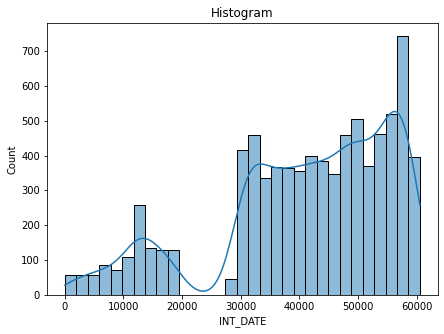

In [ ]:
plt.figure(figsize=(7,5))
sns.histplot(t, x='INT_DATE', kde=True)
plt.title('Histogram')

### How are date and number of tokens related?

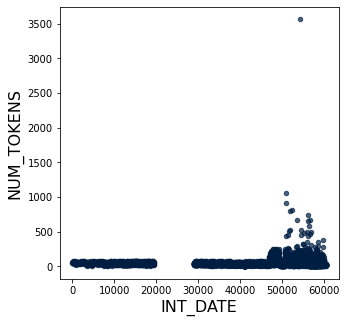

In [ ]:
t.scatter('INT_DATE', 'NUM_TOKENS')

### How are date and number of unique tokens related?

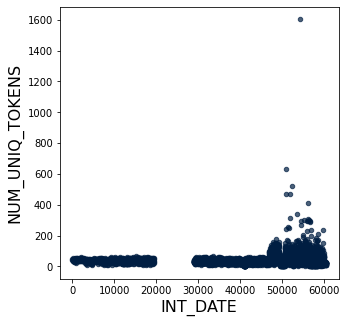

In [ ]:
t.scatter('INT_DATE', 'NUM_UNIQ_TOKENS')

### How are date and number of tokens without stop words related?

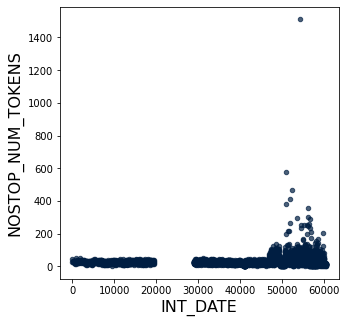

In [ ]:
t.scatter('INT_DATE', 'NOSTOP_NUM_TOKENS')

### How are date and length of the longest token related?

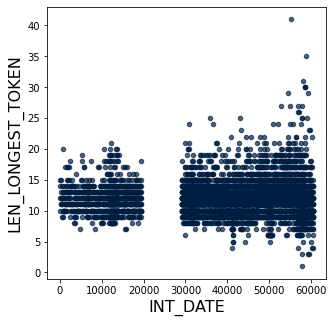

In [ ]:
t.scatter('INT_DATE', 'LEN_LONGEST_TOKEN')

### How are date and average length of tokens related?

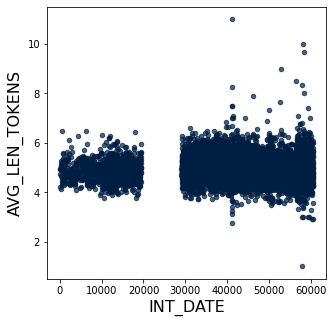

In [ ]:
t.scatter('INT_DATE', 'AVG_LEN_TOKENS')

### How are date and number of sentences related?

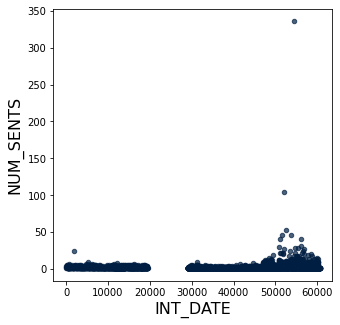

In [ ]:
t.scatter('INT_DATE', 'NUM_SENTS')

### How are date and average length of sentences related?

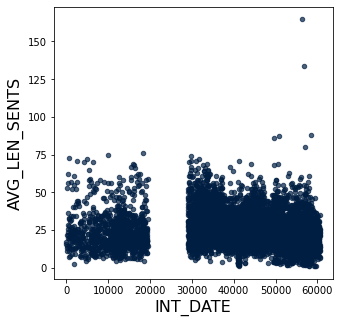

In [ ]:
t.scatter('INT_DATE', 'AVG_LEN_SENTS')

## First Hypothesis
* English would have changed to reduce the number of words in a sentence by using longer words.

## Drawing a regression line

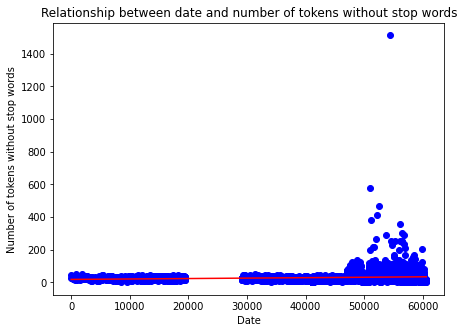

In [ ]:
x = t.column('INT_DATE')
y = t.column('NOSTOP_NUM_TOKENS')

plt.figure(figsize=(7,5))
plt.title('Relationship between date and number of tokens without stop words')
plt.scatter(x, y, color='blue')
plt.xlabel('Date')
plt.ylabel('Number of tokens without stop words')

slope, intercept = np.polyfit(x, y, deg=1)
fit = intercept + np.multiply(slope, x)
plt.plot(x, fit, '-', color='red')

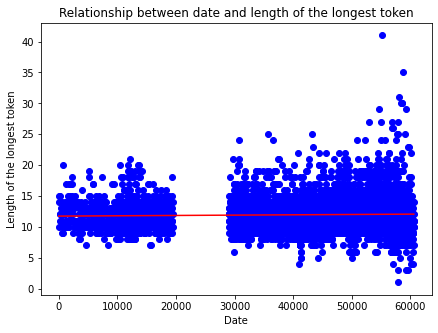

In [ ]:
y = t.column('LEN_LONGEST_TOKEN')

plt.figure(figsize=(7,5))
plt.title('Relationship between date and length of the longest token')
plt.scatter(x, y, color='blue')
plt.xlabel('Date')
plt.ylabel('Length of the longest token')

slope, intercept = np.polyfit(x, y, deg=1)
fit = intercept + np.multiply(slope, x)
plt.plot(x, fit, '-', color='red')

### Conducting statistical tests

In [ ]:
x = t.column('INT_DATE')
y = t.column('NOSTOP_NUM_TOKENS')
print('Between date and number of tokens without stop words:')
print(pearsonr(x, y))
print(spearmanr(x, y))
print()

y = t.column('LEN_LONGEST_TOKEN')
print('Between date and length of the longest token:')
print(pearsonr(x, y))
print(spearmanr(x, y))

Between date and number of tokens without stop words:
(0.1387363703829636, 1.0505851972101988e-35)
SpearmanrResult(correlation=0.04580153630857476, pvalue=4.1329747609648535e-05)

Between date and length of the longest token:
(0.031313767952656849, 0.0050745437479767655)
SpearmanrResult(correlation=0.012334879894825273, pvalue=0.26975912731400237)


* Both relationships are statistically significant because they have Pearson p-value less than 0.05.

## Second Hypothesis
* Certain words would have been used a lot a long time ago, but not anymore. Also, others would have been used less often in the past but recently increased a lot in their use frequency.

### Analyzing word frequency change over time

In [ ]:
def f(l,r):
  d = {}
  for tokens in t.where('INT_DATE', are.between(l,r))['NOSTOP_TOKENS']:
    for token in tokens:
      if token in d:
        d[token] += 1
      else:
        d[token] = 1
  return d

d_list = [f(0,365*50),f(365*50,365*100),f(365*100,365*150),f(365*150,365*200)]

1851~1900:
[('yesterday', 198), ("'s", 167), ('last', 152), ('city', 129), ('mr.', 103), ('one', 102), ('to-day', 95), ('morning', 75), ('made', 74), ('night', 74), ('new', 70), ('washington', 65), ('evening', 63), ('two', 62), ('meeting', 59), ('state', 59), ('time', 58), ('states', 57), ('new-york', 57), ('first', 57), ('committee', 56), ('john', 56), ('upon', 55), ('years', 55), ('united', 54), ('afternoon', 54), ('held', 54), ('court', 52), ('house', 52), ('men', 52), ('following', 51), ('may', 51), ('county', 48), ('received', 45), ('day', 44), ('general', 44), ("o'clock", 42), ('street', 41), ('president', 40), ('july', 40), ('board', 39), ('year', 39), ('people', 38), ('ago', 38), ('would', 38), ('railroad', 37), ('public', 37), ('days', 36), ('london', 36), ('secretary', 36), ('st.', 35), ('great', 35), ('long', 35), ('present', 35), ('number', 35), ('letter', 34), ('march', 34), ('late', 33), ('place', 33), ('members', 33), ('april', 32), ('old', 32), ('j.', 31), ('said', 31),

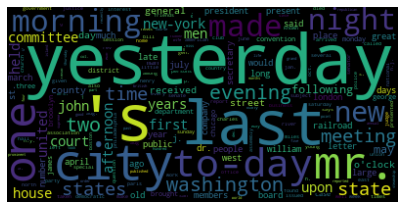


1901~1950:
[('today', 452), ("'s", 395), ('yesterday', 360), ('new', 324), ('york', 189), ('last', 172), ('washington', 154), ('united', 134), ('president', 132), ('city', 127), ('ap', 118), ('states', 116), ('year', 114), ('two', 114), ('first', 114), ('may', 108), ('one', 107), ('american', 100), ('war', 99), ('national', 95), ('state', 94), ('week', 92), ('announced', 88), ('made', 87), ('years', 87), ('said', 84), ('tonight', 81), ('street', 76), ('june', 75), ('time', 73), ('company', 73), ('july', 73), ('government', 71), ('night', 71), ('london', 70), ('day', 70), ('would', 69), ('country', 69), ('annual', 69), ('three', 69), ('oct.', 68), ('world', 67), ('nov.', 67), ('public', 67), ('general', 66), ('association', 66), ('march', 63), ('jan.', 62), ('sept.', 61), ('mrs.', 61), ('per', 61), ('committee', 61), ('april', 60), ('cent', 59), ('feb.', 58), ('aug.', 58), ('5', 57), ('club', 57), ('1', 57), ('10', 57), ('board', 57), ('john', 56), ('reported', 55), ('dec.', 54), ('men

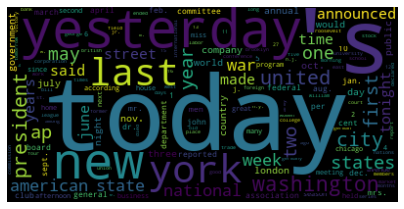


1951~2000:
[("'s", 1248), ('today', 863), ('new', 823), ('said', 559), ('yesterday', 535), ('last', 436), ('york', 413), ('one', 408), ('lead', 407), ('years', 382), ('two', 376), ('first', 341), ('president', 331), ('would', 315), ('mr.', 306), ('city', 297), ('united', 282), ('company', 280), ('may', 278), ('year', 266), ('washington', 264), ('state', 257), ('states', 251), ('american', 238), ('people', 205), ('week', 204), ('time', 200), ('three', 188), ('government', 183), ('night', 180), ('national', 178), ('federal', 175), ('world', 173), ('many', 169), ('ap', 165), ('john', 162), ('old', 161), ('made', 160), ('home', 158), ('3', 156), ('also', 156), ('june', 155), ('announced', 154), ('street', 151), ('like', 148), ('million', 143), ('house', 142), ('could', 142), ('since', 141), ('10', 141), ('march', 134), ('ago', 133), ('officials', 132), ('public', 131), ('day', 131), ("n't", 130), ('editor', 129), ('former', 125), ('april', 125), ('even', 125), ('corporation', 124), ('1', 

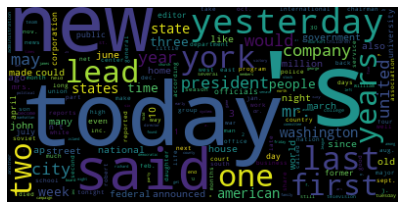


2000~2017:
[("'s", 384), ('new', 290), ('said', 184), ('one', 153), ('york', 147), ('two', 140), ('years', 133), ('last', 118), ('city', 115), ('may', 114), ('first', 113), ('world', 108), ('mr.', 107), ('would', 99), ('president', 99), ('made', 92), ('many', 92), ('family', 91), ('also', 87), ('year', 87), ('time', 86), ('like', 81), ('died', 78), ('american', 77), ('people', 75), ('state', 73), ('home', 72), ('three', 71), ('week', 71), ('day', 71), ('states', 71), ('united', 71), ('street', 71), ('wife', 69), ('times', 67), ("n't", 66), ('friday', 65), ('beloved', 64), ('could', 63), ('life', 61), ('company', 61), ('public', 60), ('take', 59), ('yesterday', 58), ('center', 58), ('group', 58), ('thursday', 58), ('house', 58), ('mother', 56), ('national', 56), ('editor', 54), ('university', 54), ('late', 53), ('school', 52), ('show', 52), ('monday', 51), ('john', 51), ('sunday', 51), ('father', 51), ('way', 50), ('former', 50), ('children', 50), ('husband', 49), ('long', 49), ('seaso

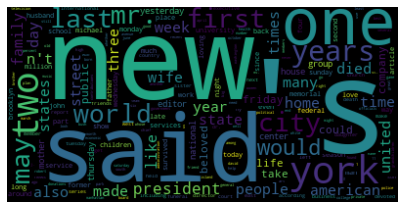

In [ ]:
def show_wordcloud(d):
  wordcloud = WordCloud().generate_from_frequencies(d)
  plt.figure(figsize=(7,5))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()

for i in range(len(d_list)-1):
  print(f'{1851+50*i}~{1900+50*i}:')
  print(sorted(d_list[i].items(), key=lambda x: x[1], reverse=True))
  show_wordcloud(d_list[i])
  print()
print('2000~2017:')
print(sorted(d_list[-1].items(), key=lambda x: x[1], reverse=True))
show_wordcloud(d_list[-1])

# 4. Conclusions

### Hypothesis 1

* The relationship between date and words in sentences is statistically significant, however, it is not strongly associated enough to create a prediction model based on this data.

### Hypothesis 2

* As expected in the hypothesis, we can observe many interesting features from the result.
* For example, the use frequency of `'yesterday'` consistently decreased over time.
* On the other hand, the frequency of `"'s"` consistently increased a lot over time.